# Loading CIFAR-10

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

In [4]:
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape  == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape  == (10000, 1)

x_train = x_train/255
x_test  = x_test/255
y_train = np.squeeze(y_train)
y_test  = np.squeeze(y_test)

data_labels = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

## Plotting some samples

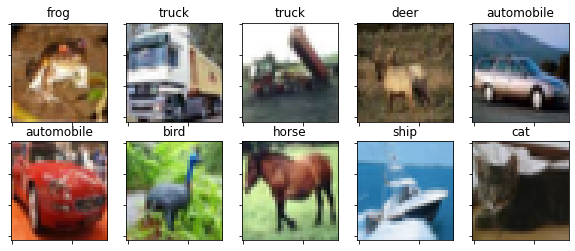

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,5, figsize=(10,4))

counter = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[counter], aspect='auto')
        ax[i,j].set_title(data_labels[y_train[counter]])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xticklabels([])
        counter += 1

## Counting labels

In [6]:
for i in data_labels.keys():
    print(f'{data_labels[i]} : {len(np.where(y_train==i)[0])}')

airplane : 5000
automobile : 5000
bird : 5000
cat : 5000
deer : 5000
dog : 5000
frog : 5000
horse : 5000
ship : 5000
truck : 5000


## Visualizations

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_history(history):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5),sharex=True)
    r = np.arange(len(history.history['loss']))+1
    ax[0].plot(r, history.history['loss'],label='Train')
    ax[0].plot(r, history.history['val_loss'],label='Validation')
    ax[0].set_ylabel('Loss Value')
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(r, history.history['accuracy'],label='Train')
    ax[1].plot(r, history.history['val_accuracy'],label='Validation')
    ax[1].set_ylabel('Accuracy Value')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()
    ax[1].grid(True)
    #name = f'Model {model_type}_Run {run}_curves.pdf'
    plt.show()
    #fig.savefig(directory/name)
    plt.close(fig)    

def confusion(model, x_test, y_test):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    print (f'accuracy = {acc}')
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(cm_norm,index = data_labels.values(), columns = data_labels.values())

    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, annot=True,cmap="YlGnBu")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Test data confusion matrix')
    plt.show()

## Timing functions
I took this part from https://stackoverflow.com/questions/5849800/what-is-the-python-equivalent-of-matlabs-tic-and-toc-functions.

In [8]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

# Data prepration

## Split validation

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

## Normalization

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pixels = 32*32*3

x_tr = np.reshape(x_train, (-1, pixels))
x_tr = scaler.fit_transform(x_tr)
x_va = np.reshape(x_valid, (-1, pixels))
x_va = scaler.transform(x_va)
x_te = np.reshape(x_test , (-1, pixels))
x_te = scaler.transform(x_te)

print(x_tr.shape, x_va.shape, x_te.shape)

(40000, 3072) (10000, 3072) (10000, 3072)


## One-hotting

In [10]:
from tensorflow.keras.utils import to_categorical

y_tr = to_categorical(y_train)
y_va = to_categorical(y_valid)
y_te = to_categorical(y_test)

print(y_tr.shape, y_va.shape, y_te.shape)

(40000, 10) (10000, 10) (10000, 10)


# MLP

## MLP definition

In [11]:
from tensorflow.keras.layers import Dense, Dropout, Input, Softmax, Activation

def get_mlp(layers, dropout = 0, act = tf.nn.relu):
    model = keras.Sequential()
    model.add(Input(shape=(layers[0],)))
    
    depth = len(layers)-1
    for i in range(1, depth+1):
        model.add(Dense(units=layers[i], name=f'dense-{i}'))
        if i != depth:
            model.add(Activation(act, name=f'activation-{i}'))
            if dropout > 0:
                model.add(Dropout(rate=dropout))
        else:
            model.add(Softmax(axis=1, name='softmax'))
    return model

## MLP training

In [14]:
layers = [pixels, 1000, 250, 10]
model  = get_mlp(layers)

# building the model using a dummy input
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model.predict(dummy) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense-1 (Dense)             (None, 1000)              3073000   
                                                                 
 activation-1 (Activation)   (None, 1000)              0         
                                                                 
 dense-2 (Dense)             (None, 250)               250250    
                                                                 
 activation-2 (Activation)   (None, 250)               0         
                                                                 
 dense-3 (Dense)             (None, 10)                2510      
                                                                 
 softmax (Softmax)           (None, 10)                0         
                                                                 
Total params: 3,325,760
Trainable params: 3,325,760
Non-

In [15]:
lr = 0.01
bs = 500
ep = 600

er_stop = keras.callbacks.EarlyStopping(
    monitor= 'val_loss',patience=75,restore_best_weights=True
)

model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

Epoch 1/600
80/80 - 2s - loss: 1.7858 - accuracy: 0.3756 - val_loss: 1.5828 - val_accuracy: 0.4413 - 2s/epoch - 25ms/step
Epoch 2/600
80/80 - 1s - loss: 1.4598 - accuracy: 0.4929 - val_loss: 1.5079 - val_accuracy: 0.4707 - 932ms/epoch - 12ms/step
Epoch 3/600
80/80 - 1s - loss: 1.3237 - accuracy: 0.5434 - val_loss: 1.4600 - val_accuracy: 0.4925 - 777ms/epoch - 10ms/step
Epoch 4/600
80/80 - 1s - loss: 1.2182 - accuracy: 0.5801 - val_loss: 1.4269 - val_accuracy: 0.4988 - 737ms/epoch - 9ms/step
Epoch 5/600
80/80 - 1s - loss: 1.1211 - accuracy: 0.6195 - val_loss: 1.4030 - val_accuracy: 0.5098 - 755ms/epoch - 9ms/step
Epoch 6/600
80/80 - 1s - loss: 1.0370 - accuracy: 0.6482 - val_loss: 1.4148 - val_accuracy: 0.5148 - 790ms/epoch - 10ms/step
Epoch 7/600
80/80 - 1s - loss: 0.9546 - accuracy: 0.6825 - val_loss: 1.4205 - val_accuracy: 0.5183 - 788ms/epoch - 10ms/step
Epoch 8/600
80/80 - 1s - loss: 0.8753 - accuracy: 0.7125 - val_loss: 1.4212 - val_accuracy: 0.5182 - 798ms/epoch - 10ms/step
Epoch

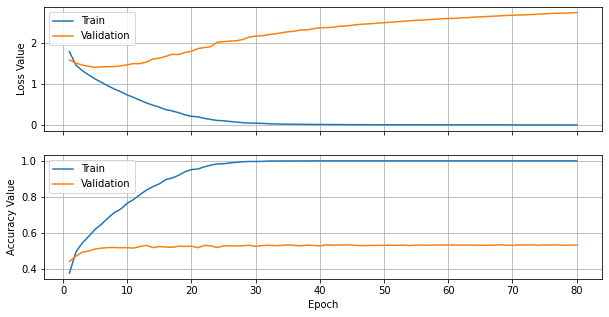

accuracy = 0.5186


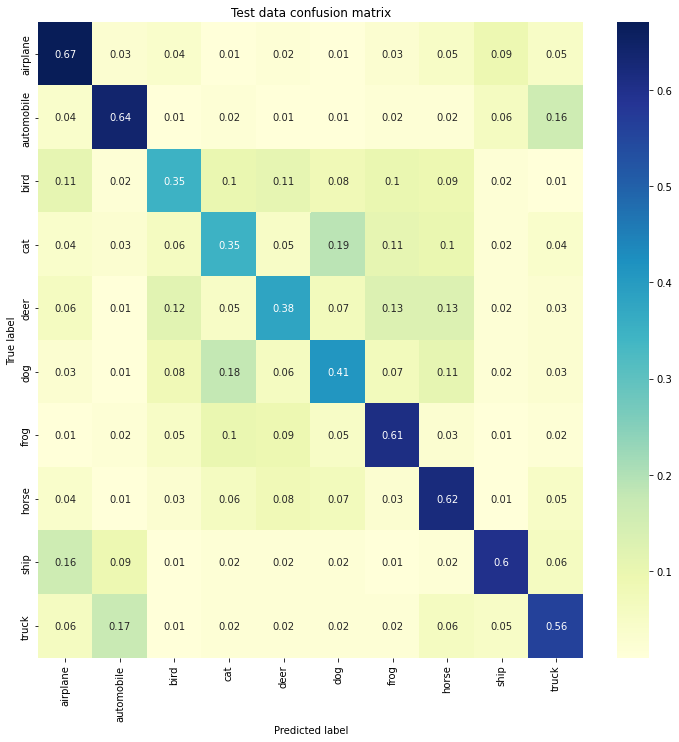

In [ ]:
hist = model.fit(
    x_tr, y_tr,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_va),
    verbose=2, callbacks = [er_stop]
)

plot_history(hist)
confusion(model, x_te, y_test)

## A. Effect of batch size


### BS = 64

Elapsed time: 269.032525 seconds.



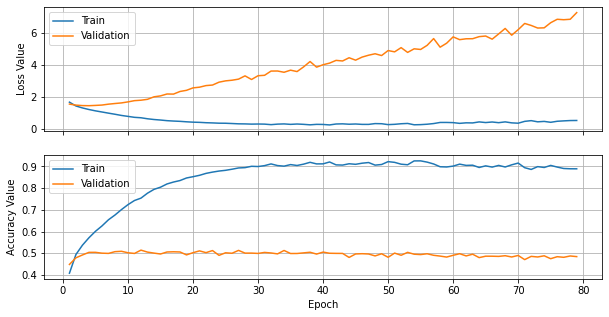

accuracy = 0.5003


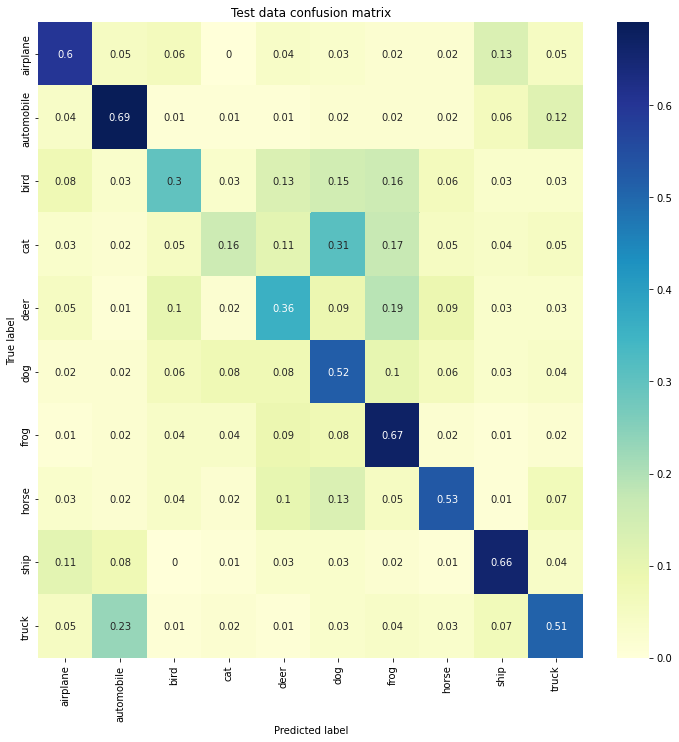

In [ ]:
model1  = get_mlp(layers)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model1.predict(dummy)

bs = 64

model1.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist1 = model1.fit(
    x_tr, y_tr,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_va),
    verbose=0, callbacks = [er_stop]
)
toc()

plot_history(hist1)
confusion(model1, x_te, y_test)

### BS = 32

Elapsed time: 492.058026 seconds.



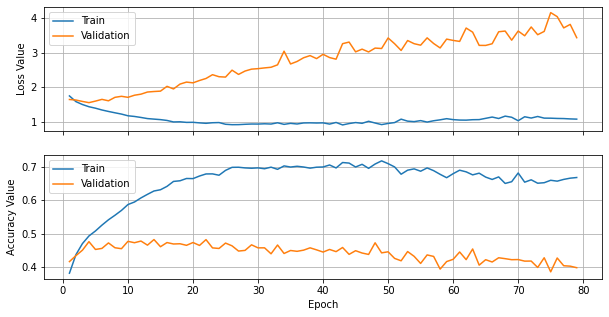

accuracy = 0.4656


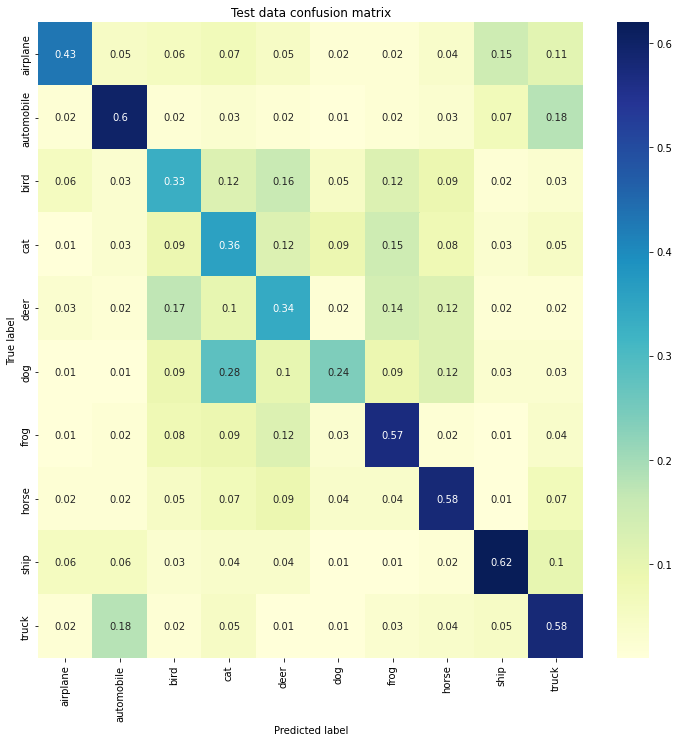

In [ ]:
model2  = get_mlp(layers)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model2.predict(dummy)

bs = 32

model2.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist2 = model2.fit(
    x_tr, y_tr,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_va),
    verbose=0, callbacks = [er_stop]
)
toc()

plot_history(hist2)
confusion(model2, x_te, y_test)

### BS = 256

Elapsed time: 95.983405 seconds.



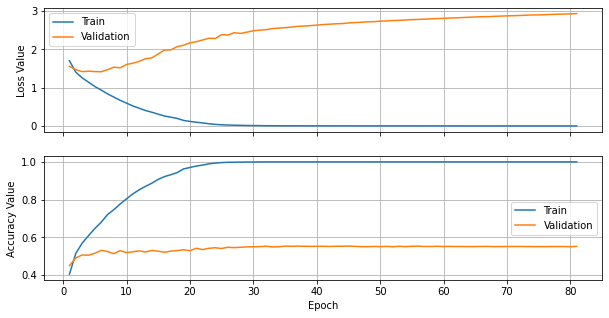

accuracy = 0.5213


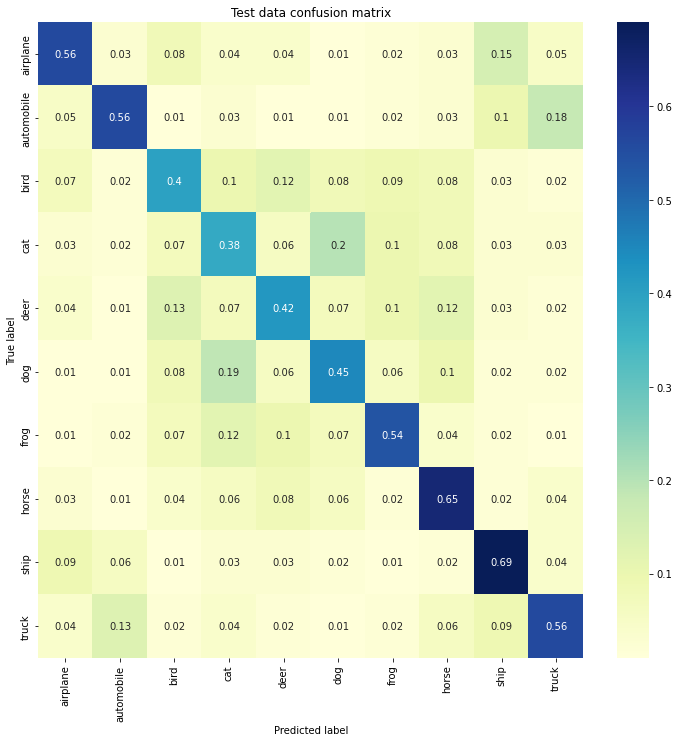

In [ ]:
model3  = get_mlp(layers)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model3.predict(dummy)

bs = 256

model3.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist3 = model3.fit(
    x_tr, y_tr,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_va),
    verbose=0, callbacks = [er_stop]
)
toc()

plot_history(hist3)
confusion(model3, x_te, y_test)

In [ ]:
print(len(hist3.history['val_loss']))
95.983405 / len(hist3.history['val_loss'])

81


1.1849803086419755

## B. Effect of activation function
We have already used `ReLU`. Now we train a network using `tanh`. We use the best hyperparameters from previous section.

Elapsed time: 91.847838 seconds.



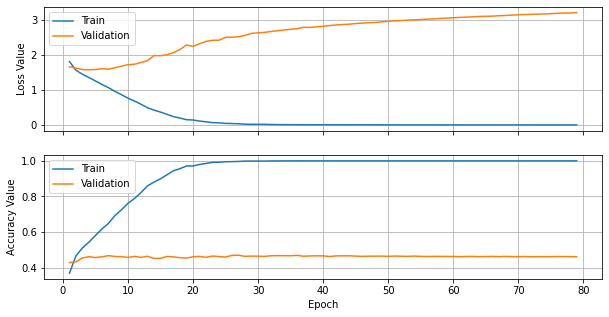

accuracy = 0.4604


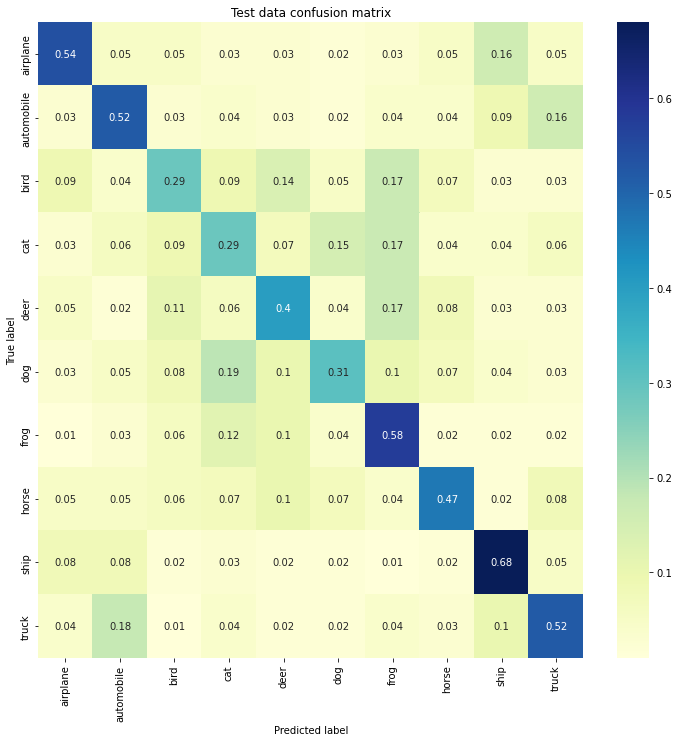

In [ ]:
model4  = get_mlp(layers, act=tf.math.tanh)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model4.predict(dummy)

bs = 256

model4.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist4 = model4.fit(
    x_tr, y_tr,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_va),
    verbose=0, callbacks = [er_stop]
)
toc()

plot_history(hist4)
confusion(model4, x_te, y_test)

## C. Effect of loss function
We have already seen networks trained using `CrossEntropy`. Now we train network using `MSE` as loss function.

First we convert our labels to one-hot.

Elapsed time: 152.223880 seconds.



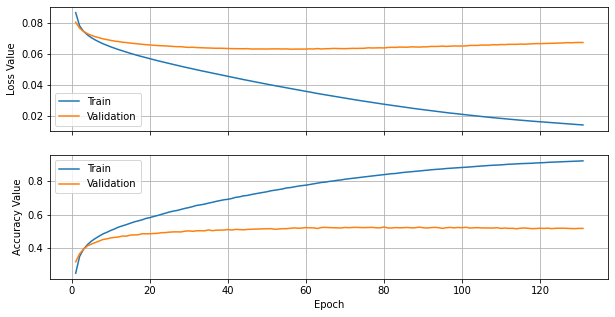

accuracy = 0.515


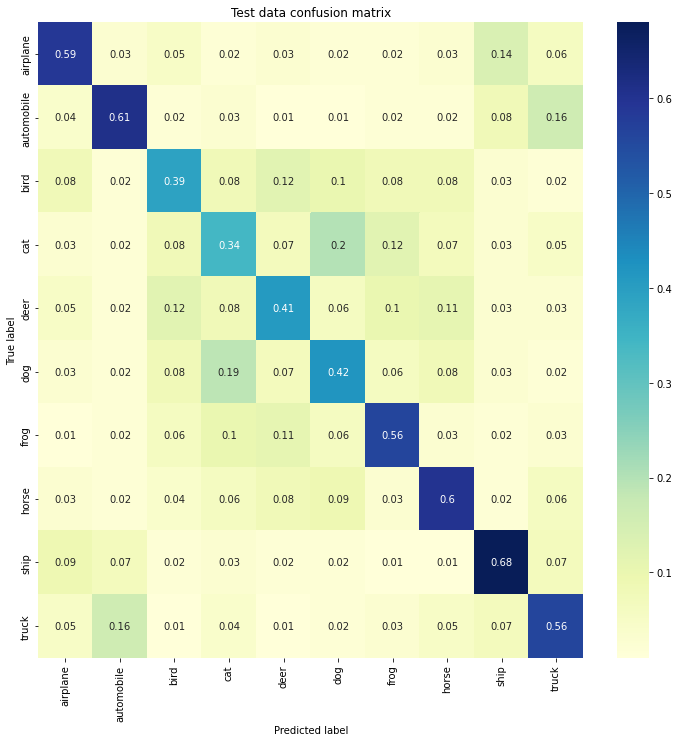

In [ ]:
model5  = get_mlp(layers)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model5.predict(dummy)

bs = 256

model5.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    loss = keras.losses.MeanSquaredError(),
    metrics = ['accuracy']
)

tic()
hist5 = model5.fit(
    x_tr, y_tr,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_va),
    verbose=0, callbacks = [er_stop]
)
toc()

plot_history(hist5)
confusion(model5, x_te, y_test)

## D. Effect of Optimizer

### Adam (lr=0.01)

Elapsed time: 106.964232 seconds.



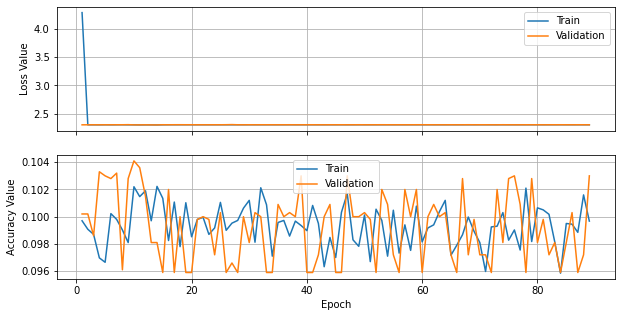

accuracy = 0.1001


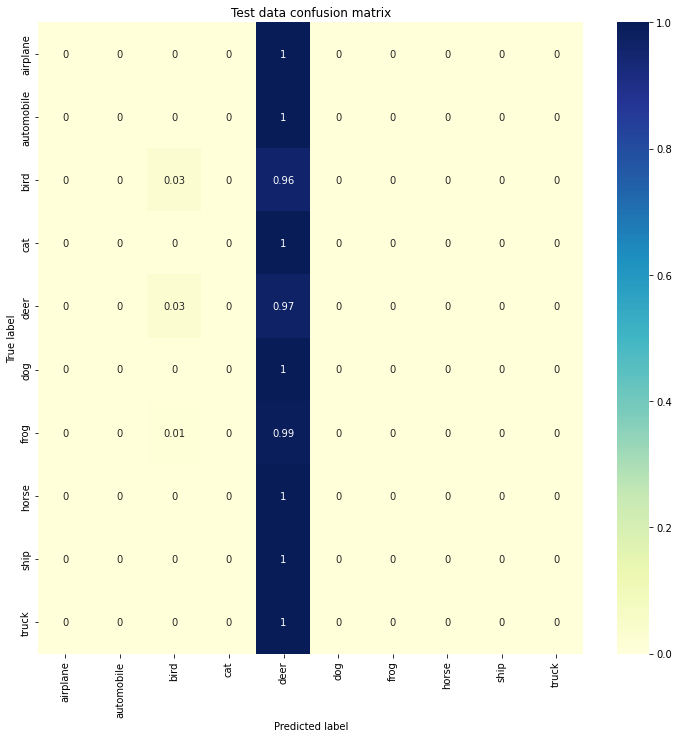

In [ ]:
model6  = get_mlp(layers)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model6.predict(dummy)

bs = 256
lr = 0.01

model6.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

tic()
hist6 = model6.fit(
    x_tr, y_tr,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_va),
    verbose=0, callbacks = [er_stop]
)
toc()

plot_history(hist6)
confusion(model6, x_te, y_test)

### Adam (lr=0.001)

Elapsed time: 96.005848 seconds.



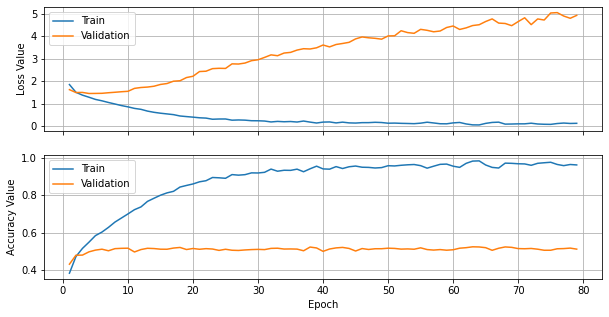

accuracy = 0.4917


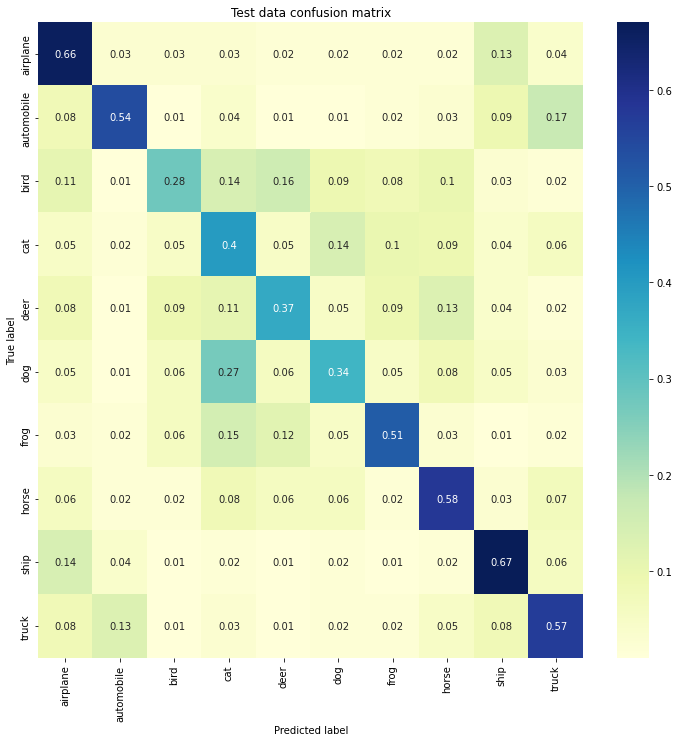

In [ ]:
model7  = get_mlp(layers)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model7.predict(dummy)

bs = 256
lr = 0.001

model7.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

tic()
hist7 = model7.fit(
    x_tr, y_tr,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_va),
    verbose=0, callbacks = [er_stop]
)
toc()

plot_history(hist7)
confusion(model7, x_te, y_test)

## E. Other metrics

In [ ]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model3.predict(x_te), axis=1)
print (classification_report(y_test, y_pred, target_names=list(data_labels.values())))

              precision    recall  f1-score   support

    airplane       0.60      0.56      0.58      1000
  automobile       0.64      0.56      0.60      1000
        bird       0.45      0.40      0.42      1000
         cat       0.36      0.38      0.37      1000
        deer       0.45      0.42      0.43      1000
         dog       0.46      0.45      0.45      1000
        frog       0.55      0.54      0.55      1000
       horse       0.54      0.65      0.59      1000
        ship       0.59      0.69      0.63      1000
       truck       0.58      0.56      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000



## F. Unbalanced dataset
If the number of samples in classes are not equal to each other, then we have an unbalanced dataset. This can bias our model to learn the prominent classes. To solve this problem, we can use **weight training**. We make greater updates using small-number classes.

## G. Train on unbalanced dataset

### Deleting some training samples

In [18]:
data_labels = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

def delete(x_train, y_train, classes=[0, 2], percent=0.5):
    x = np.copy(x_train)
    y = np.copy(y_train)
    for c in classes:
        I = np.where(y==c)[0] # indices
        N = len(I) # number of samples
        P = np.random.permutation(N) # Permute
        L = np.int32(np.floor(0.5*N)) # deletions
        d = I[P][:L]
        x = np.delete(x, d, axis=0)
        y = np.delete(y, d, axis=0)
    return x, y

In [20]:
x, y = delete(x_tr, y_train)
print ('*** class sizes after deleting ***')
for i in data_labels.keys():
    print(f'{data_labels[i]} : {len(np.where(y==i)[0])}')

*** class sizes after deleting ***
airplane : 2015
automobile : 3991
bird : 1989
cat : 3986
deer : 4014
dog : 3941
frog : 4005
horse : 4014
ship : 4037
truck : 4005


### Class weight definition

In [16]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y),
    y = y
)

cw = dict()
for ii, w in enumerate(class_weights):
    cw[ii] = w
print(cw)

{0: 1.7864516129032257, 1: 0.9019543973941369, 2: 1.8098039215686275, 3: 0.9030858003010537, 4: 0.8967862481315396, 5: 0.913397614818574, 6: 0.8988014981273408, 7: 0.8967862481315396, 8: 0.891676987862274, 9: 0.8988014981273408}


### Train using class weights

Elapsed time: 116.504076 seconds.



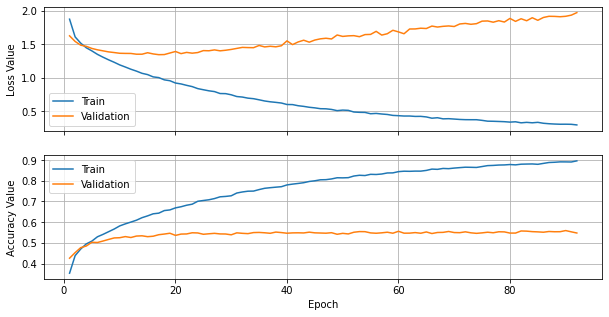

accuracy = 0.5428


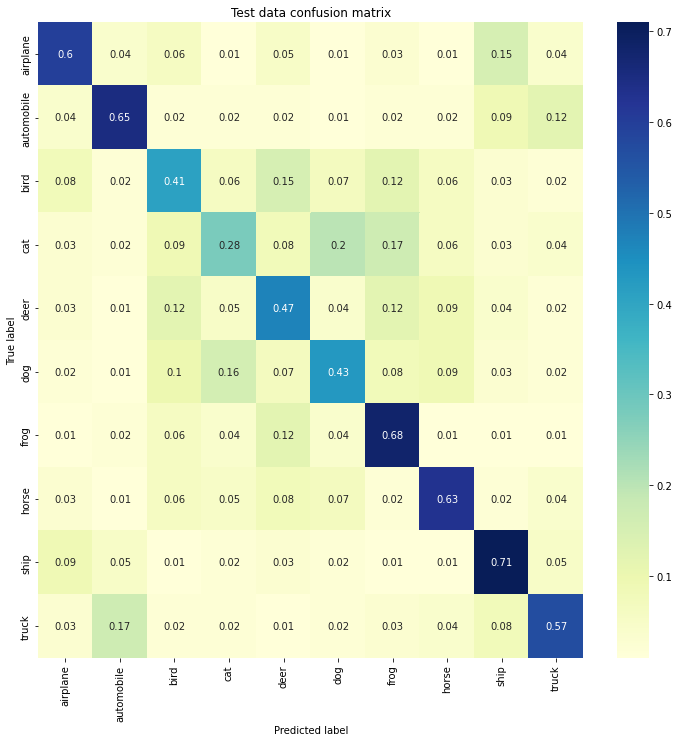

In [21]:
model8  = get_mlp(layers, dropout=0.25)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model8.predict(dummy)
y_onehot = to_categorical(y)

bs = 256
lr = 0.01
ep = 500

er_stop = keras.callbacks.EarlyStopping(
    monitor= 'val_loss',patience=75,restore_best_weights=True
)

model8.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

tic()
hist8 = model8.fit(
    x, y_onehot,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_va),
    class_weight = cw,
    verbose=0, callbacks = [er_stop]
)
toc()

plot_history(hist8)
confusion(model8, x_te, y_test)

In [24]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model8.predict(x_te), axis=1)
print (classification_report(y_test, y_pred, target_names=list(data_labels.values())))

              precision    recall  f1-score   support

    airplane       0.62      0.59      0.61      1000
  automobile       0.66      0.65      0.66      1000
        bird       0.43      0.41      0.42      1000
         cat       0.39      0.28      0.33      1000
        deer       0.44      0.47      0.46      1000
         dog       0.47      0.43      0.45      1000
        frog       0.53      0.68      0.59      1000
       horse       0.62      0.63      0.63      1000
        ship       0.60      0.71      0.65      1000
       truck       0.61      0.57      0.59      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000



# CNN

## CNN definition

In [22]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Dense, Softmax

def get_cnn(fc_layer, dropout=0, pool=False, bn=False):
    model = keras.Sequential()
    model.add(Conv2D(9, 5, activation='relu'))
    if bn:
        model.add(BatchNormalization())
    if pool:
        model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(27, 5, activation='relu'))
    if bn:
        model.add(BatchNormalization())
    if pool:
        model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    for ii, l in enumerate(fc_layer):
        model.add(Dense(units=l, activation='relu'))
        if dropout > 0 and ii < len(fc_layer)-1:
            model.add(Dropout(rate=dropout))
        if ii == len(fc_layer)-1:
            model.add(Softmax(axis=1, name='softmax'))
    return model

## A. Conv layers

In [29]:
model = get_cnn(fc_layer=[1000,250,10])
dummy = tf.random.normal(x_train[0:2,:].shape)
_ = model.predict(dummy) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 9)         684       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 27)        6102      
                                                                 
 flatten_2 (Flatten)         (None, 15552)             0         
                                                                 
 dense_6 (Dense)             (None, 1000)              15553000  
                                                                 
 dense_7 (Dense)             (None, 250)               250250    
                                                                 
 dense_8 (Dense)             (None, 10)                2510      
                                                                 
 softmax (Softmax)           (None, 10)               

In [32]:
lr = 0.01
bs = 256
ep = 600

er_stop = keras.callbacks.EarlyStopping(
    monitor= 'val_loss', patience=75, restore_best_weights=True
)

model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

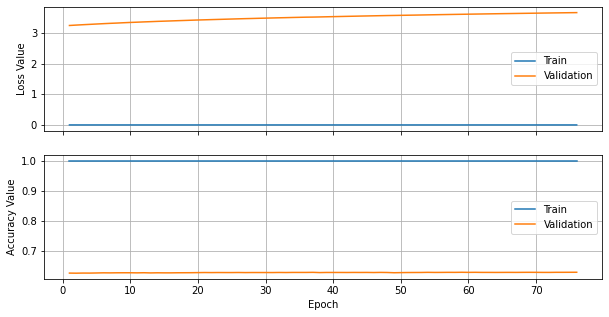

accuracy = 0.6197


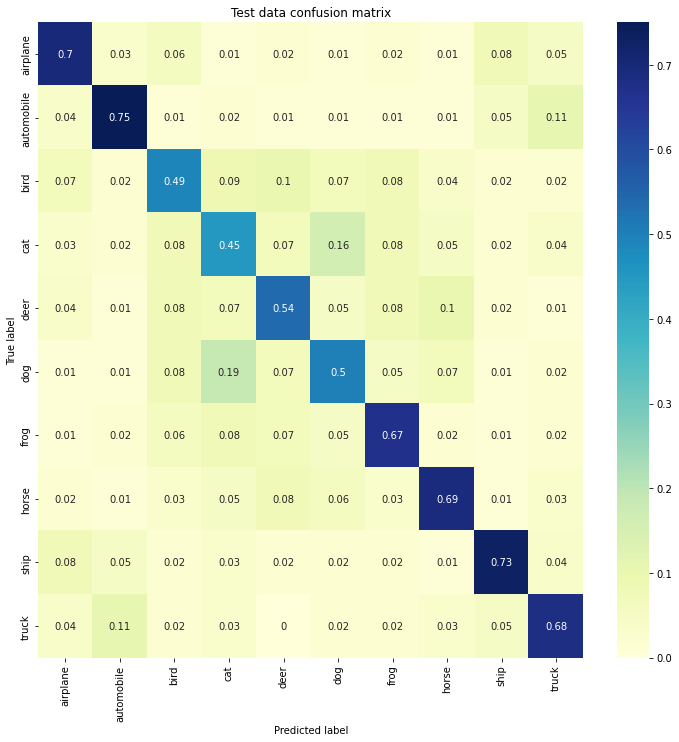

In [33]:
hist = model.fit(
    x_train, y_tr,
    batch_size = bs, epochs = ep,
    validation_data = (x_valid,y_va),
    verbose=0, callbacks = [er_stop]
)

plot_history(hist)
confusion(model, x_test, y_test)

## B. Pool and BN

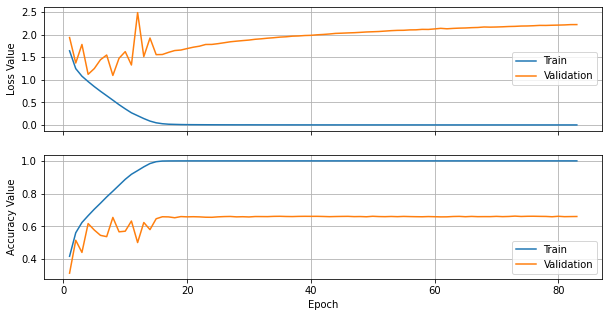

accuracy = 0.6486


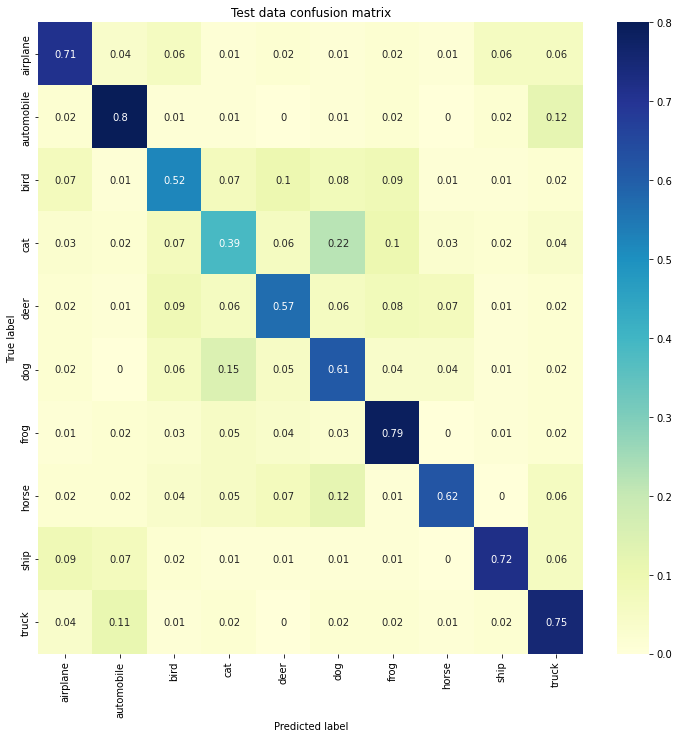

In [35]:
model2 = get_cnn(fc_layer=[1000,250,10], pool=True, bn=True)
dummy = tf.random.normal(x_train[0:2,:].shape)
_ = model2.predict(dummy)

model2.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist2 = model2.fit(
    x_train, y_tr,
    batch_size = bs, epochs = ep,
    validation_data = (x_valid,y_va),
    verbose=0, callbacks = [er_stop]
)
toc()

plot_history(hist2)
confusion(model2, x_test, y_test)

## C. Dropout

Elapsed time: 204.528999 seconds.



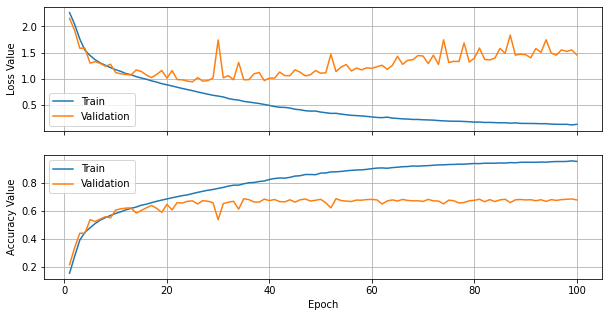

accuracy = 0.6734


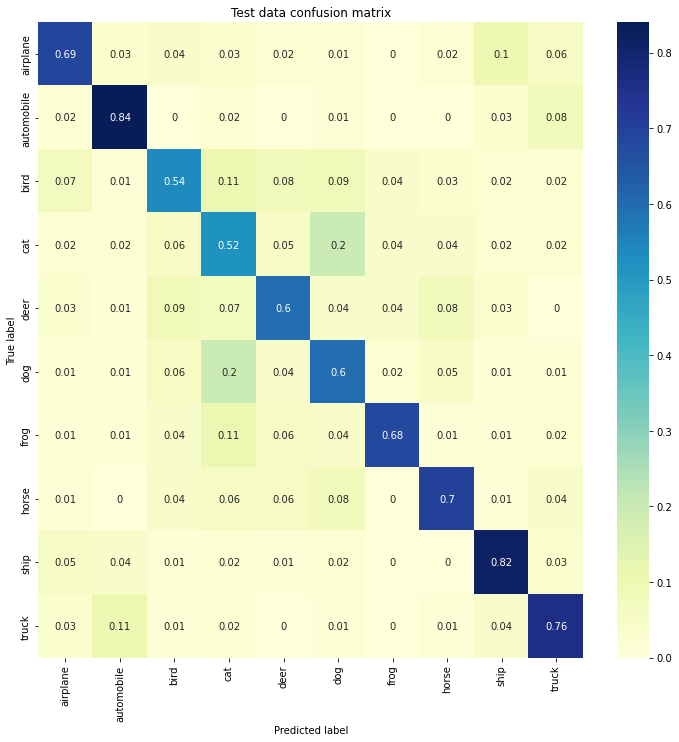

In [38]:
model3 = get_cnn(fc_layer=[1000,250,10], pool=True, bn=True, dropout=0.5)
dummy = tf.random.normal(x_train[0:2,:].shape)
_ = model3.predict(dummy)

model3.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist3 = model3.fit(
    x_train, y_tr,
    batch_size = bs, epochs = ep,
    validation_data = (x_valid,y_va),
    verbose=0, callbacks = [er_stop]
)
toc()

plot_history(hist3)
confusion(model3, x_test, y_test)